## Data Exploration/Analysis

Ultimate goal is to predict median sale price per square foot of a house in the neighborhood.

Current step: EDA

Next step: PCA and Clustering. See what patterns emerge in the clusters.

Final step: predict median sale price.

## Observations:

Multifamily is listed with a 'Land Area' of 0.

Condos/apartments, no matter how tall their building, are listed with a height of 1 :/



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
%run jsoncleaner.py

In [17]:
df.head()

,Assessment Classification,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds,Building Condition,Building Grade,Building Type,...,Most Recent Sale Price Improved,Square Footage Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Land Area Acres,Story Height Custom,Building Type Custom
0,RES,"$86,825","$20,000","$106,825",2019,3.0,4.0,Average,C,SINGLE FAM,...,435000,4035,347300.0,106825.0,80000.0,20000.0,427300.0,2.9,2.0,SINGLE FAM
1,RES,"$85,200","$20,000","$105,200",2019,3.0,4.0,Average,C,SINGLE FAM,...,434900,3273,340800.0,105200.0,80000.0,20000.0,420800.0,2.6,1.5,SINGLE FAM
2,RES,"$46,650","$20,000","$66,650",2019,3.0,3.0,Average,C,SINGLE FAM,...,345000,2331,186600.0,66650.0,80000.0,20000.0,266600.0,2.6,1.5,SINGLE FAM
3,RES,"$46,650","$20,000","$66,650",2019,3.0,3.0,Average,C,SINGLE FAM,...,345000,2331,186600.0,66650.0,80000.0,20000.0,266600.0,2.6,1.5,SINGLE FAM
4,RES,"$19,050","$20,800","$39,850",2019,1.0,3.0,Average,C,SINGLE FAM,...,155000,1328,76200.0,39850.0,83200.0,20800.0,159400.0,2.4,1.0,SINGLE FAM


In [ ]:
df=df

In [16]:
df['Land Value Improved'].head()
#Adjacent parcels will often all have the same appraised land value. Appraised values are not generally useful for our purposes.

0    80000.0
1    80000.0
2    80000.0
3    80000.0
4    83200.0
Name: Land Value Improved, dtype: float64

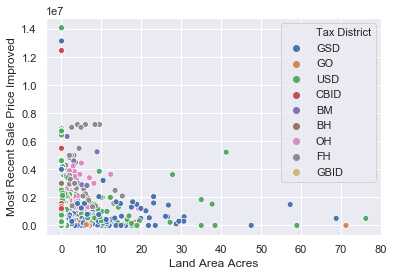

In [3]:
sns.scatterplot(y=df['Most Recent Sale Price Improved'],x=df['Land Area Acres'], hue = df['Tax District'])

In [ ]:
#Many neighborhoods only have 1 or 2 observations. We need to delete neighborhoods with 3 or less observations.
df['Neighborhood'].value_counts()
#.gt() = 'greater than'
s=df.Neighborhood.value_counts().gt(3)
df.loc[df.Neighborhood.isin(s[s].index)].shape
#Removes 124 observations from original dataframe.

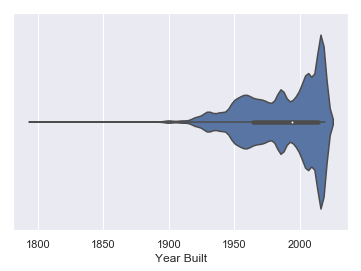

In [4]:
sns.violinplot(df['Year Built'])

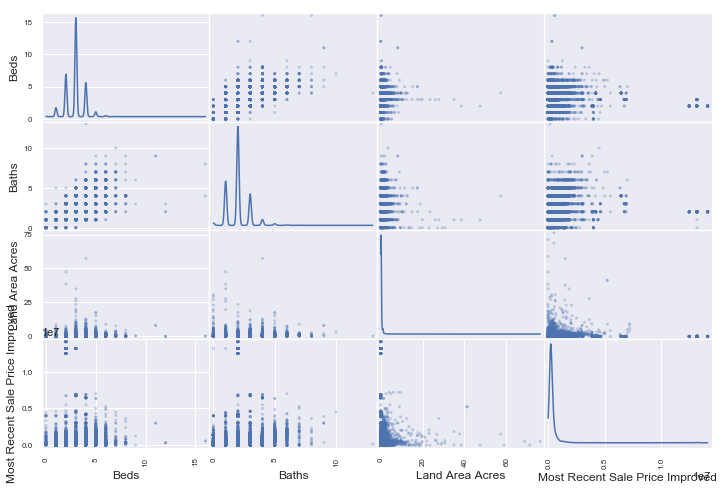

In [5]:
pd.plotting.scatter_matrix(df[['Beds','Baths', 'Land Area Acres','Most Recent Sale Price Improved']], alpha = 0.3,figsize = (12,8), diagonal = 'kde');

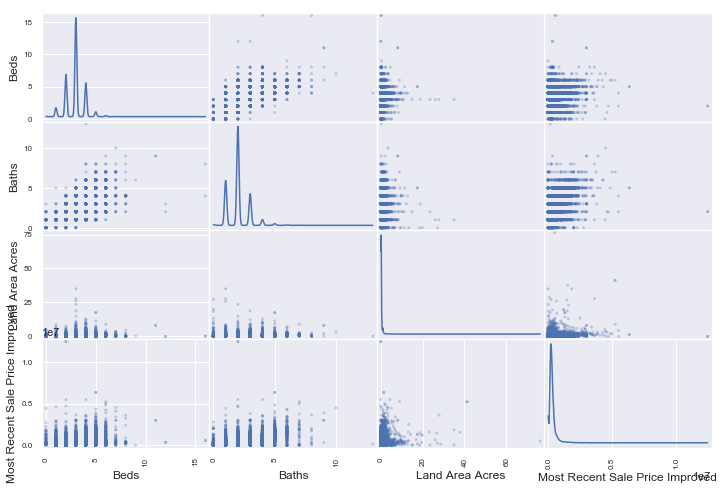

In [28]:
#Now let's take out multi-parcel sales.
df=df[df['Multiple Parcels Involved in Sale'] == "No"]
pd.plotting.scatter_matrix(df[['Beds','Baths', 'Land Area Acres','Most Recent Sale Price Improved']], alpha = 0.3,figsize = (12,8), diagonal = 'kde');

1       31695
2       25577
nan      4645
1.5      4500
1.75     2812
3        1791
1.25      472
2.5       147
2.25       95
2.75       62
4          24
Name: Story Height, dtype: int64
1.00    31695
2.00    25577
1.50     7312
3.00     1791
1.25      472
2.50      147
2.25       95
2.75       62
4.00       24
Name: Story Height Custom, dtype: int64


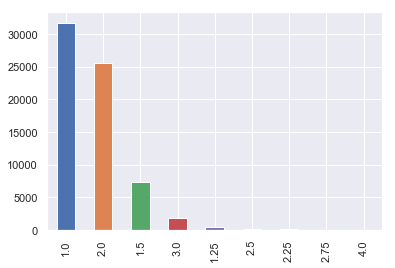

In [27]:
print(df['Story Height'].value_counts())

df['Story Height Custom'].value_counts().plot('bar')

print(df['Story Height Custom'].value_counts())

In [10]:
len(df['Neighborhood'].unique())
#This will be getting pretty granular. We should consider trends among Zones as well.

830

2    16934
1    13569
6    12704
8     9930
7     7337
3     5202
9     2465
4     2053
5     1626
Name: Zone, dtype: int64


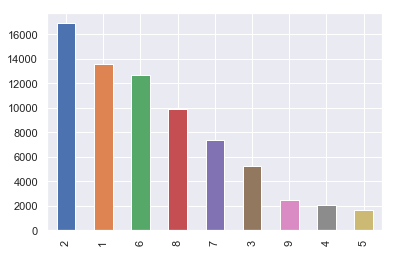

In [11]:
df.Zone.value_counts().plot('bar')
print(df.Zone.value_counts())

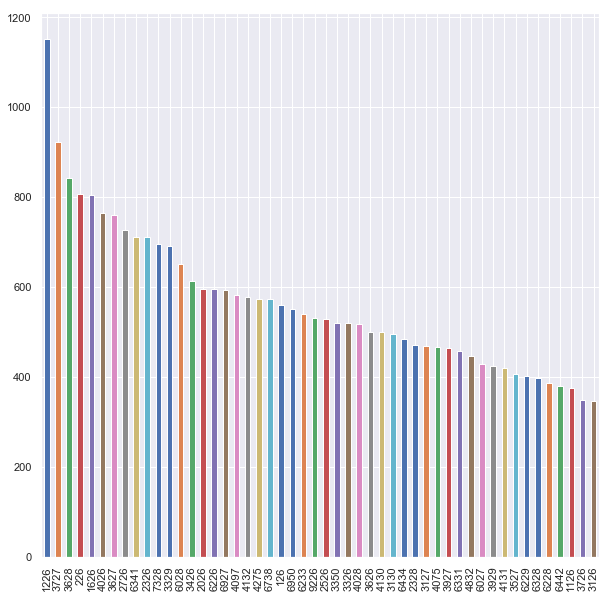

In [12]:
plt.figure(figsize=(10,10))
df.Neighborhood.value_counts()[:50].plot('bar')
plt.show()
#Nice even class distribution

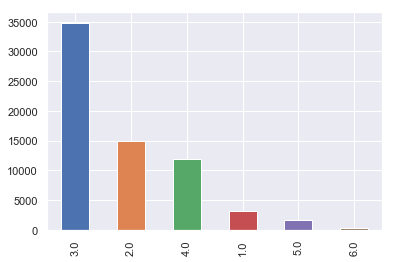

In [13]:
df.Beds.value_counts()[:6].plot('bar')

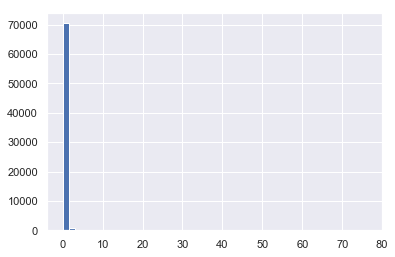

In [14]:
df['Land Area Acres'].hist(bins=50)
#We have some outliers, consider removing
#Important observation: the vsat majority of these units are multifamily (land area of 0)

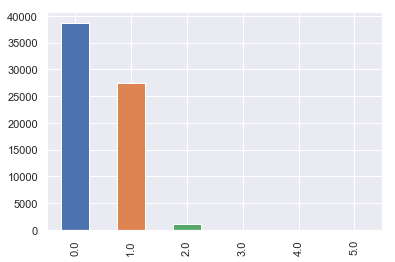

In [9]:
#Add 0.5 to Baths for each "half bath" listed?
#Or not. This is a potential indicator of PPSF
df['Half Bath'].value_counts().plot('bar')

In [8]:
df['Building Condition'].value_counts()
#I think this kind of class imbalance makes it useful for predictive purposes; if anything's different from 'Average' that's significant

Average        65906
Fair             761
Good             271
Poor             119
Very Good         49
Very Poor         34
Dilapidated       25
Excellent         11
Name: Building Condition, dtype: int64

In [ ]:
df['Building Grade'].value_counts()
#We cannot use this variable. There is no guide on the Davidson CO site as to what these indicate.

In [7]:
print(df['Building Type'].value_counts())
#Not a real useful variable without cleaning.

SINGLE FAM      46556
RESD CONDO      15977
ZERO LOT         1558
HRISE CONDO      1194
RES DUPLEX       1040
R1 DUPLEX         284
RH SING FAM       189
MODULAR HOME       82
RW SING FAM        78
RESD TRIPLEX       71
RESD QUADPLX       33
RETAIL/SHPG        30
CHURCH             23
RY SING FAM        20
OFFICE             19
APARTMENT           4
REST/BAR            4
WAREHOUSE           3
DAYCARE             2
RZ SING FAM         2
HIGHRISE APT        2
HEALTH CLUB         1
MARKET              1
GROCERY/SMKT        1
LODGE/FRAT'L        1
Name: Building Type, dtype: int64


In [19]:
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
column = df.groupby('Neighborhood').mean()
column['Mean PPS'] = column['Sale Price'] / column['Square Footage Improved']
column['Mean PPS']=column['Mean PPS'].replace(np.inf, np.nan)
column['Mean PPS'].unique()
meansales = pd.DataFrame(column['Mean PPS'])
df=df.merge(meansales,how = 'left', on = 'Neighborhood')

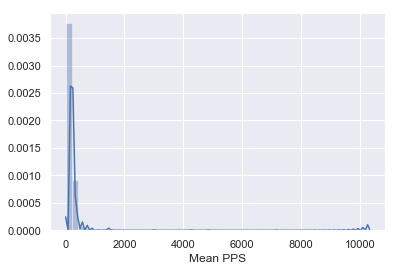

In [20]:
sns.distplot(df['Mean PPS'].dropna())
#This is why we remove multi-parcel sales. But what are these other outliers?